In [29]:
# Imports and add ons

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
import os
import Bio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from pathlib import Path

In [2]:
# Load the clean data into variables
Processed_Folder = Path(r"ANN.ipynb").parent.absolute() / Path("Processed Data")

dicts = ['EFI_ID_List', 'metabolite_dict', 'Protein_seq_dict']

with open(Processed_Folder / Path('EFI_ID_List.p'), 'rb') as EFI_ID:
    EFI_ID_List = pickle.load(EFI_ID)

with open(Processed_Folder / Path('metabolite_dict.p'), 'rb') as metabolite:
    metabolite_dict = pickle.load(metabolite)

with open(Processed_Folder / Path('Protein_seq_dict.p'), 'rb') as Protein_seq:
    Protein_seq_dict = pickle.load(Protein_seq)

activations = pd.read_csv(Processed_Folder / Path('activations.csv'), index_col=0)

In [3]:
# Log number of amino acids in each protein into dictionary
def amino_acid_counter(Protein_Seq):
    from Bio.Seq import Seq
    from Bio.Alphabet import IUPAC
    from Bio.Alphabet.IUPAC import IUPACProtein
    
    my_prot = Seq(Protein_Seq, IUPAC.protein).upper()
    amino_acids = list(IUPACProtein.letters)
    acid_dict = {amino_acids[i]: 0 for i in range(0, len(amino_acids))}
    
    for amino_acid in amino_acids:
        acid_dict[amino_acid] = my_prot.count(amino_acid)
    
    # print(acid_dict)
    return(acid_dict)

In [4]:
# Encodes protein sequence using one-hot method and counting
def one_hot_encoder_count(ID_List:list, Protein_Dict:dict):
    from Bio.Seq import Seq
    from Bio.Alphabet import IUPAC
    from Bio.Alphabet.IUPAC import IUPACProtein

    num_acids = len(IUPACProtein.letters)
    num_proteins = len(Protein_Dict)

    encoded_data = np.zeros((num_proteins, num_acids))

    for i in range(0,len(ID_List)):
        ID = ID_List[i]
        P_seq = Protein_Dict[ID]
        acid_dict = amino_acid_counter(Protein_Seq=P_seq)
        encoded_data[i,:] = list(list(acid_dict.values()))
        
    encoded_data = encoded_data.astype(np.int)

    print(encoded_data)
    return(encoded_data)

In [5]:
# How to use amino_acid_counter
Protein_seq_list = list(Protein_seq_dict.values())
P_seq = Protein_seq_list[1]
acid_dict = amino_acid_counter(P_seq)
list(acid_dict.values())

[21, 3, 11, 13, 2, 19, 4, 12, 9, 18, 3, 2, 9, 5, 8, 5, 8, 14, 3, 6]

In [38]:
# Encoding the data into input data for neural network
input_data = one_hot_encoder_count(ID_List=EFI_ID_List, Protein_Dict=Protein_seq_dict)

# Specify outputs of data, lets use just 1 of the activation rows
true_outputs = activations.to_numpy()[0,:]

[[ 8  1 10 ...  5  4  5]
 [21  3 11 ... 14  3  6]
 [25  7 12 ... 12  6  0]
 ...
 [65  4 39 ... 49  4  3]
 [19  1 11 ... 13  0  4]
 [29  3 18 ... 11  5  2]]


In [74]:
# Make neural networks using Keras

max_val = np.amax(input_data)

inputs = keras.Input(shape=(len(input_data[0])))

x = layers.experimental.preprocessing.Rescaling(1/max_val)(inputs)

x = layers.Dense(100, activation="sigmoid")(x)

x = layers.Dense(100, activation="sigmoid")(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
rescaling_10 (Rescaling)     (None, 20)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 100)               2100      
_________________________________________________________________
dense_32 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
Total params: 12,301
Trainable params: 12,301
Non-trainable params: 0
_________________________________________________________________


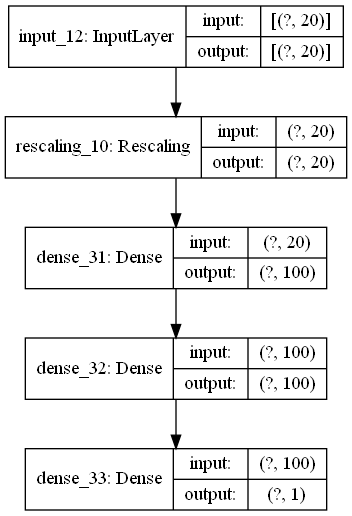

In [75]:
keras.utils.plot_model(model, "my_first_model.png",show_shapes=True)

In [80]:
# Split known data into train, and test
X_train, X_test, y_train, y_test = train_test_split(input_data, true_outputs, test_size=0.2)

# Split train data into train and CV
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"]
)
history = model.fit(X_train, y_train, epochs=1, validation_split=0.2)
test_scores = model.evaluate(X_test, y_test, verbose=2)
print(X_test)
print(y_test)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

5/5 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.0504 - val_loss: 0.0000e+00 - val_accuracy: 0.0857
2/2 - 0s - loss: 0.0000e+00 - accuracy: 0.0909
[[40  3 17 20  3 19  4  4  8 38  4  4 17  6 23  7 17 25  7  6]
 [12  4 16 16  7 13  2 20 20 22  5 13  6 10  6  9  9 11  1 17]
 [ 7  3 15 16 15  9  3 24 26 30  4 18  4  2  3 19 12  6  2 10]
 [20  3 14 16 13 16  5 13  8 25  4 12  8 11 10 11 13 12  6  5]
 [17  3 18 20 12 13  4 14 19 23  7  7 12  4 12 10  4 13  1  5]
 [20  3 18 11  7 12  6 10 11 14  8  6  9  9  8  7  8 16  3  5]
 [27  3 11 11  9 18  4 17  6 29  2  8  8 15 11 17  8 10  3  2]
 [26  0 40 40 23 42 15 41 34 31 12 12 21 14 14 24 25 32  4 16]
 [17  0 13 25 11 13  3 14 22 26  7  9  5  6 13 11 10 22  4  4]
 [18  1 13 20 14 16  6 15 11 14  9  7  6  8  8 10 19  9  1 10]
 [18  2 18 20 11 12  3 23 24 33  8 16  8 12  5 17 14 17  1  7]
 [ 9  9 15 22 14 13  6 22 15 18  7 14 10  6  8 15  9 12  3  8]
 [26  3 30 28 19 22  8 26 26 52  5 23 10 12  9 16 18 22  4 17

In [ ]:
from Bio.Alphabet.IUPAC import IUPACProtein

print(IU)